In [1]:
!pip install gym-gridworlds

In [2]:
!pip install plotting

In [3]:
!rm -r ../multiagentparticleenvs/
!git clone https://github.com/vlb9ae/multiagent-particle-envs.git

rm: cannot remove '../multiagentparticleenvs/': No such file or directory
Cloning into 'multiagent-particle-envs'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 367 (delta 96), reused 126 (delta 92), pack-reused 234
Receiving objects: 100% (367/367), 127.88 KiB | 5.81 MiB/s, done.
Resolving deltas: 100% (222/222), done.


In [4]:
%mv multiagent-particle-envs/ multiagentparticleenvs/

In [5]:
%cd multiagentparticleenvs/

/content/multiagentparticleenvs


In [6]:
!ls

bin	     make_env.py  plotting_custom.py  setup.py
LICENSE.txt  multiagent   README.md


In [7]:
!pip install gym==0.10.5

     |████████████████████████████████| 1.5MB 4.5MB/s 
  Created wheel for gym: filename=gym-0.10.5-cp37-none-any.whl size=1581309 sha256=4bd0a59f500de4906d746be60b1cec32421680f068a2546d37c7a5c147c6a2e6
  Stored in directory: /root/.cache/pip/wheels/cb/14/71/f4ab006b1e6ff75c2b54985c2f98d0644fffe9c1dddc670925
Successfully built gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [8]:
import gym
import gym_gridworlds
import itertools
import matplotlib
import matplotlib.style
import numpy as np
import pandas as pd

In [9]:
from plotting_custom import EpisodeStats

In [10]:
from multiagentparticleenvs.make_env import make_env

from collections import defaultdict
matplotlib.style.use('ggplot')

# env = make_env('extra_landmark_speaker_listener')
env = make_env('simpler_speaker_listener')
#env = make_env('simple_speaker_listener')
#env = make_env('simple')
#env = gym.make('Cliff-v0')

#Epsilon Greedy Policy Definition

In [11]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based
    on a given Q-function and epsilon.
       
    Returns a function that takes the state
    as an input and returns the probabilities
    for each action in the form of a numpy array 
    of length of the action space(set of possible actions).
    """
    def policyFunction(state):
   
        Action_probabilities = np.ones(num_actions,
                dtype = float) * epsilon / num_actions
                  
        best_action = np.argmax(Q[state])
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities
   
    return policyFunction

#UCB Policy Definition

In [12]:
def UCBPolicy(Q, N, c, t, state):
  
  best_action = 0
  best_q_val = float('-inf')
  for i in range(len(N)):
    if N[i] > 0:
      cur_q_val = Q[state][i] + c*np.sqrt(np.log(t)/N[i])
    else:
      cur_q_val = Q[state][i]
    if cur_q_val > best_q_val:
      best_q_val = cur_q_val
      best_action = i

  return best_action

#Normal qLearning

In [13]:
def qLearning(env, num_episodes, discount_factor = 1.0,
                            alpha = 0.6, epsilon = 0.1):
    """
    Q-Learning algorithm: Off-policy TD control.
    Finds the optimal greedy policy while improving
    following an epsilon-greedy policy"""
       
    # Action value function
    # A nested dictionary that maps
    # state -> (action -> action-value).

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
   
    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes))    


    # Create an epsilon greedy policy function
    # appropriately for environment action space
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n)
       
    # For every episode
    for ith_episode in range(num_episodes):
           
        # Reset the environment and pick the first action
        state = env.reset()
        print(state)

        for t in itertools.count():
               
            # get probabilities of all actions from current state
            action_probabilities = policy(state)
   
            # choose action according to 
            # the probability distribution
            action = np.random.choice(np.arange(
                      len(action_probabilities)),
                       p = action_probabilities)
   
            # take action and get reward, transit to next state
            next_state, reward, done, _ = env.step(action)
   
            # Update statistics
            stats.episode_rewards[ith_episode] += reward
            stats.episode_lengths[ith_episode] = t
               
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
   
            # done is True if episode terminated   
            if done:
                break
                   
            state = next_state
       
    return Q, stats

#multi_agent_qLearning

In [14]:
def multi_agent_qLearning(env, num_episodes, discount_factor = 1.0,
                            alpha = 0.6, epsilon = 0.1):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """
       
    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    stats = []
    policy = []

    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: np.zeros(env.action_space[ind].n)))
    
      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )
        
      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    for ith_episode in range(num_episodes):

        states = env.reset()
        #stores action probabilities assigned to each action at every step
        actions = []
        action_probs = []
        #loops through each agent
        for ind, (q,stat, p,state,agent) in enumerate(zip(Q, stats, policy, states, env.agents)):
          
          # get probabilities of all actions from current state for each agent
          action_probabilities = p(tuple(state))

          action = np.random.choice(np.arange(
                    len(action_probabilities)),
                    p = action_probabilities)
          
          for i in range(len(action_probabilities)):
            if i == action:
              action_probabilities[i] = 1
            else:
              action_probabilities[i] = 0
          
          action_probs.append(action_probabilities)
          actions.append(action)

        
        #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
        next_state, reward, done, _ = env.step(action_probs)
        #next_state -> set of states for each agent
        #reward -> array of rewards for each agent
        #done -> whether or not learning is finished
        #loops through each agent
        for ind, (q,stat, p,state,agent) in enumerate(zip(Q, stats, policy, states, env.agents)):

          #used to keep track of episode count        
          for t in itertools.count():
    
              # Update statistics
              stat.episode_rewards[ith_episode] += reward[ind]
              stat.episode_lengths[ith_episode] = t
              
              #choose action given probabilities for each agent
              action = actions[ind]

              # RUQL approximation algorithm, models Equation 4 from the paper
              #q -> q table for each agent
              #state -> state for each agent
              #action -> selected best action for each agent
              best_next_action = np.argmax(q[tuple(next_state[ind])])    
              td_target = reward + discount_factor * q[tuple(next_state[ind])][best_next_action]
              td_delta = td_target - q[tuple(state)][action]
              q[tuple(state)][action] += alpha * td_delta
    
              # done is True if episode terminated   
              if done:
                  break
                    
              states = next_state[ind]

    return Q, stats

#Communication counting helper

In [15]:
def comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW):
  if np.array_equal(env.world.agents[0].goal_b.color, RED):
    if action == 0:
      communication_count[0] += 1
    if action == 1:
      communication_count[1] += 1
    if action == 2:
      communication_count[2] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, GREEN):
    if action == 0:
      communication_count[3] += 1
    if action == 1:
      communication_count[4] += 1
    if action == 2:
      communication_count[5] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, BLUE):
    if action == 0:
      communication_count[6] += 1
    if action == 1:
      communication_count[7] += 1
    if action == 2:
      communication_count[8] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, CYAN):
    if action == 0:
      communication_count[9] += 1
    if action == 1:
      communication_count[10] += 1
    if action == 2:
      communication_count[11] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, MAGENTA):
    if action == 0:
      communication_count[12] += 1
    if action == 1:
      communication_count[13] += 1
    if action == 2:
      communication_count[14] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, YELLOW):
    if action == 0:
      communication_count[15] += 1
    if action == 1:
      communication_count[16] += 1
    if action == 2:
      communication_count[17] += 1

  return communication_count

#Multi_agent_RUQL

In [16]:
def RU_qLearning(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """
       
    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))
    
      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )
        
      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    for ith_episode in range(num_episodes):

        #stores action probabilities assigned to each action at every step
        actions = []
        action_probs = []
        
        if ith_episode > 0:
          alpha = (1000 + 1)/(1000 + ith_episode)

        if (ith_episode / num_episodes > cutoff):
          cutoff += .1
          epsilon /= 2
          env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

        for ind, (q,stat, p,state,agent) in enumerate(zip(Q, stats, policy, prev_state, env.agents)):
          
          #Create new policy function based on updated Q table for a given agent
          policy[ind] = createEpsilonGreedyPolicy(q, epsilon, env.action_space[ind].n)
          p = policy[ind]

          #Get probability distribution over actions from policy
          action_probabilities = p(tuple(state))

          #Choose an action using the probability distribution over actions
          action = np.random.choice(np.arange(
                    len(action_probabilities)),
                    p = action_probabilities)

          #One-hot encode the chosen action so it is definitely chosen in env.step()
          for i in range(len(action_probabilities)):
            if i == action:
              action_probabilities[i] = 1
            else:
              action_probabilities[i] = 0
          
          #action_probs -> stores one-hot encoded action for each agent
          action_probs.append(action_probabilities)
          #actions -> stores action chosen for each agent
          actions.append(action)

        #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
        next_state, reward, done, _ = env.step(action_probs)

        #make rewards positive to allow policy function to choose argmin rather than argmax
        reward = np.asarray(reward)
        #next_state -> set of states for each agent
        #reward -> array of rewards for each agent
        #done -> whether or not learning is finished
        #loops through each agent
        for ind, (q,stat, p,state,agent) in enumerate(zip(Q, stats, policy, prev_state, env.agents)):

          stat.episode_rewards[ith_episode] += reward[ind]
          stat.episode_lengths[ith_episode] = 1
          
          #choose action given probabilities for each agent
          action = actions[ind]
          if ind == 0:
            if np.array_equal(env.world.agents[0].goal_b.color, RED):
              if action == 0:
                communication_count[0] += 1
              if action == 1:
                communication_count[1] += 1
              if action == 2:
                communication_count[2] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, GREEN):
              if action == 0:
                communication_count[3] += 1
              if action == 1:
                communication_count[4] += 1
              if action == 2:
                communication_count[5] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, BLUE):
              if action == 0:
                communication_count[6] += 1
              if action == 1:
                communication_count[7] += 1
              if action == 2:
                communication_count[8] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, CYAN):
              if action == 0:
                communication_count[9] += 1
              if action == 1:
                communication_count[10] += 1
              if action == 2:
                communication_count[11] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, MAGENTA):
              if action == 0:
                communication_count[12] += 1
              if action == 1:
                communication_count[13] += 1
              if action == 2:
                communication_count[14] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, YELLOW):
              if action == 0:
                communication_count[15] += 1
              if action == 1:
                communication_count[16] += 1
              if action == 2:
                communication_count[17] += 1


          if ind == 1:
            if q[tuple(state)].sum() == 0:
              unseen += 1

          # RUQL approximation algorithm, models Equation 4 from the RUQL paper
          #q -> q table for each agent
          #state -> state for each agent
          #action -> selected best action for each agent
          
          # RUQL
          left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
          right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
          best_next_action = np.argmin(q[tuple(next_state[ind])])    
          td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
          right_term *= td_target
          q[tuple(state)][action] = left_term + right_term

        prev_state = next_state

    return Q, stats, unseen, communication_count

#Multi-agent RUQL with Bandit-style UCB exploration


In [17]:
def RUQL_UCB_Bandit(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """
       
    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    V = []
    N = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))
      V.append(defaultdict(lambda: (0)))

      N.append(np.zeros(env.action_space[ind].n))
    
      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )
        
      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    t_vals = []

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []
          
          if t > 0:
            alpha = (200 + 1)/(200 + t)

          #if (ith_episode / num_episodes > cutoff):
          #  cutoff += .1
          #  epsilon /= 2
            #env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy
            action = UCBPolicy(q, n, 2, v[tuple(state)], tuple(state))

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1
            
            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          reward = np.asarray(reward)
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, state,agent) in enumerate(zip(Q, stats, prev_state, env.agents)):

            stat.episode_rewards[ith_episode] += reward[ind]
            stat.episode_lengths[ith_episode] = t
            
            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1

            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent
            
            # RUQL
            left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
            right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
            best_next_action = np.argmax(q[tuple(next_state[ind])])    
            td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
            right_term *= td_target
            q[tuple(state)][action] = left_term + right_term

          prev_state = next_state
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0
          if repeat_count > 10:
            t_vals.append(t)
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            repeat_count = 0
            break

          prev_reward = reward[0]

    print("Average H value", np.average(np.asarray(t_vals)))

    return Q, stats, communication_count

#Multi-agent QL with Hoeffding Style UCB exploration

In [18]:
def RUQL_UCB(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
       
    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    V = []
    N = []
    stats = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (200*np.ones(env.action_space[ind].n))))
      N.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))

      V.append(defaultdict(lambda: (0)))
    
      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )
        

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []
          
          if t > 0:
            alpha = (200 + 1)/(200 + t)

          #if (ith_episode / num_episodes > cutoff):
          #  cutoff += .1
          #  epsilon /= 2
            #env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy
            #action = UCBPolicy(q, n, 2, v[tuple(state)], tuple(state))
            action = np.argmax(q[tuple(state)])

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1
              else:
                action_probabilities[i] = 0
            
            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          reward = np.asarray(reward)
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            stat.episode_rewards[ith_episode] += reward[ind]
            stat.episode_lengths[ith_episode] = t
            
            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1

            
            #UCB-Hoeffding algorithm implementation
            temp = n[tuple(state)][action]
            n[tuple(state)][action] += 1
          
            if t > 0:
              iota = np.log((25*env.action_space[ind].n*num_episodes*t)/.1)
            else:
              iota = np.log((25*env.action_space[ind].n*num_episodes)/.1)
            bonus = 2*np.sqrt(((200**3)*iota)/temp)
            #print(type(v[tuple(next_state[ind])]))
            q[tuple(state)][action] = (1 - alpha)*q[tuple(state)][action] + alpha*(reward[ind] + v[tuple(next_state[ind])] + bonus)
            #print(np.argmax(q[tuple(state)]))
            v[tuple(state)] = np.argmax(q[tuple(state)])



            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent
            
            #left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
            #right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
            #best_next_action = np.argmax(q[tuple(next_state[ind])])    
            #td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
            #right_term *= td_target
            #q[tuple(state)][action] = left_term + right_term

          prev_state = next_state
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0
          if repeat_count > 20:
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            repeat_count = 0
            break

          prev_reward = reward[0]

    return Q, stats, communication_count

#EXP3-DH

In [19]:
def EXP3_DH(env, num_episodes, beta = 10, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """
       
    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    stats = []
    seen_states = []
    weights = []
    probs = []
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):
    
      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)))
      
      weights.append(np.zeros(env.action_space[ind].n))

      
      #calculate probabilities for each action
      prob = []
      for i in range(env.action_space[ind].n):
        term = (1 - epsilon)
        term *= np.exp(weights[ind][i])
        term *= 1/(np.sum(np.exp(weights[ind])))
        term += epsilon/env.action_space[ind].n
        prob.append(term)

      probs.append(prob)

    # For every episode
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    cutoff = .2

    for ith_episode in range(num_episodes):

        #Update epsilon based on time step
        if ith_episode > 0:  
          epsilon = ith_episode ** (-.2)

        #stores action probabilities assigned to each action at every step
        actions = []
        action_probs = []

        #For every cutoff % completion, change the color to ensure the speaker learns to change colors correctly
        if (ith_episode / num_episodes > cutoff):
          cutoff += .2
          env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

        for ind, (weight, stat, state, agent) in enumerate(zip(weights, stats, prev_state, env.agents)):
          
          #Define K to be the number of actions for the current agent
          K = env.action_space[ind].n

          #Calculate probabilities for each action using equation defined in Step 4 of the algorithm
          p = []
          for i in range(K):
            p_i = (1 - epsilon)
            p_i *= np.exp(weight[i] - np.max(weight))
            p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
            if p_i == float("inf"):
              print("Infinity weights", weight)
            p_i += epsilon/K
            p.append(p_i)

          probs[ind] = p

          #Define action_probabilities to be the probability distribution over actions
          action_probabilities = np.asarray(p)

          #Choose an action using the probability distribution over actions
          action = np.random.choice(np.arange(
                    len(action_probabilities)),
                    p = action_probabilities)


          #print(action_probabilities)
          #One-hot encode the chosen action so it is definitely chosen in env.step()
          for i in range(len(action_probabilities)):
            if i == action:
              action_probabilities[i] = 1
            else:
              action_probabilities[i] = 0
          
          #action_probs -> stores one-hot encoded action for each agent
          action_probs.append(action_probabilities)
          #actions -> stores action chosen for each agent
          actions.append(action)

        #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
        next_state, reward, done, _ = env.step(action_probs)

        #make rewards positive to allow policy function to choose argmin rather than argmax
        #next_state -> set of states for each agent
        #reward -> array of rewards for each agent
        #done -> whether or not learning is finished
        reward = np.asarray(reward)
        #loops through each agent
        for ind, (stat, prob, state, agent) in enumerate(zip(stats, probs, prev_state, env.agents)):

          #Define K to be the number of actions for the current agent
          K = env.action_space[ind].n

          #Update statistics with rewards
          stat.episode_rewards[ith_episode] += reward[ind]
          stat.episode_lengths[ith_episode] = 1
          
          #choose action given probabilities for each agent
          action = actions[ind]


          #Calculate payoff estimate for each action (0 for every non-chosen action)
          payoff_estimate = []
          for i in range(K):
            if i == action:
              payoff_estimate.append(reward[ind]/prob[i])
            else:
              payoff_estimate.append(0)

          #Calculate weight for each action using Equation 8 in algorithm
          weight = []
          for i in range(K):
            weight.append((ith_episode/(ith_episode + 1))**(beta)*weights[ind][i] + payoff_estimate[i])

          weights[ind] = np.asarray(weight)


          if ind == 0:
            if np.array_equal(env.world.agents[0].goal_b.color, RED):
              if action == 0:
                communication_count[0] += 1
              if action == 1:
                communication_count[1] += 1
              if action == 2:
                communication_count[2] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, GREEN):
              if action == 0:
                communication_count[3] += 1
              if action == 1:
                communication_count[4] += 1
              if action == 2:
                communication_count[5] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, BLUE):
              if action == 0:
                communication_count[6] += 1
              if action == 1:
                communication_count[7] += 1
              if action == 2:
                communication_count[8] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, CYAN):
              if action == 0:
                communication_count[9] += 1
              if action == 1:
                communication_count[10] += 1
              if action == 2:
                communication_count[11] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, MAGENTA):
              if action == 0:
                communication_count[12] += 1
              if action == 1:
                communication_count[13] += 1
              if action == 2:
                communication_count[14] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, YELLOW):
              if action == 0:
                communication_count[15] += 1
              if action == 1:
                communication_count[16] += 1
              if action == 2:
                communication_count[17] += 1

        
        prev_state = next_state

    return stats, communication_count

#EXP3

In [20]:
def EXP3(env, num_episodes, beta = 10, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """
       
    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    stats = []
    seen_states = []
    weights = []
    probs = []
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):
    
      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)))
      
      weights.append(np.zeros(env.action_space[ind].n))

      
      #calculate probabilities for each action
      prob = []
      for i in range(env.action_space[ind].n):
        term = (1 - epsilon)
        term *= np.exp(weights[ind][i])
        term *= 1/(np.sum(np.exp(weights[ind])))
        term += epsilon/env.action_space[ind].n
        prob.append(term)

      probs.append(prob)

    # For every episode
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    cutoff = .2

    for ith_episode in range(num_episodes):

        #Update epsilon based on time step
        if ith_episode > 0:  
          epsilon = ith_episode ** (-.2)

        #stores action probabilities assigned to each action at every step
        actions = []
        action_probs = []

        #For every cutoff % completion, change the color to ensure the speaker learns to change colors correctly
        if (ith_episode / num_episodes > cutoff):
          cutoff += .2
          env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

        for ind, (weight, stat, state, agent) in enumerate(zip(weights, stats, prev_state, env.agents)):
          
          #Define K to be the number of actions for the current agent
          K = env.action_space[ind].n

          #Calculate probabilities for each action using equation defined in Step 4 of the algorithm
          p = []
          for i in range(K):
            p_i = (1 - epsilon)
            p_i *= np.exp(weight[i] - np.max(weight))
            p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
            if p_i == float("inf"):
              print("Infinity weights", weight)
            p_i += epsilon/K
            p.append(p_i)

          probs[ind] = p

          #Define action_probabilities to be the probability distribution over actions
          action_probabilities = np.asarray(p)

          #Choose an action using the probability distribution over actions
          action = np.random.choice(np.arange(
                    len(action_probabilities)),
                    p = action_probabilities)


          #print(action_probabilities)
          #One-hot encode the chosen action so it is definitely chosen in env.step()
          for i in range(len(action_probabilities)):
            if i == action:
              action_probabilities[i] = 1
            else:
              action_probabilities[i] = 0
          
          #action_probs -> stores one-hot encoded action for each agent
          action_probs.append(action_probabilities)
          #actions -> stores action chosen for each agent
          actions.append(action)

        #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
        next_state, reward, done, _ = env.step(action_probs)

        #make rewards positive to allow policy function to choose argmin rather than argmax
        #next_state -> set of states for each agent
        #reward -> array of rewards for each agent
        #done -> whether or not learning is finished
        reward = np.asarray(reward)
        #loops through each agent
        for ind, (stat, prob, state, agent) in enumerate(zip(stats, probs, prev_state, env.agents)):

          #Define K to be the number of actions for the current agent
          K = env.action_space[ind].n

          #Update statistics with rewards
          stat.episode_rewards[ith_episode] += reward[ind]
          stat.episode_lengths[ith_episode] = 1
          
          #choose action given probabilities for each agent
          action = actions[ind]


          #Calculate payoff estimate for each action (0 for every non-chosen action)
          payoff_estimate = []
          for i in range(K):
            if i == action:
              payoff_estimate.append(reward[ind]/prob[i])
            else:
              payoff_estimate.append(0)

          #Calculate weight for each action using Equation 8 in algorithm

          weights[ind] = np.asarray(weights[ind])*np.exp(epsilon*np.asarray(payoff_estimate)/K)


          if ind == 0:
            if np.array_equal(env.world.agents[0].goal_b.color, RED):
              if action == 0:
                communication_count[0] += 1
              if action == 1:
                communication_count[1] += 1
              if action == 2:
                communication_count[2] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, GREEN):
              if action == 0:
                communication_count[3] += 1
              if action == 1:
                communication_count[4] += 1
              if action == 2:
                communication_count[5] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, BLUE):
              if action == 0:
                communication_count[6] += 1
              if action == 1:
                communication_count[7] += 1
              if action == 2:
                communication_count[8] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, CYAN):
              if action == 0:
                communication_count[9] += 1
              if action == 1:
                communication_count[10] += 1
              if action == 2:
                communication_count[11] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, MAGENTA):
              if action == 0:
                communication_count[12] += 1
              if action == 1:
                communication_count[13] += 1
              if action == 2:
                communication_count[14] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, YELLOW):
              if action == 0:
                communication_count[15] += 1
              if action == 1:
                communication_count[16] += 1
              if action == 2:
                communication_count[17] += 1

        
        prev_state = next_state

    return stats, communication_count

#Results

In [21]:
e = 1000
#RUQL_Q, RUQL_stats, unseen, RUQL_comm = RU_qLearning(env, e)
RUQL_UCB_BANDIT_Q, RUQL_UCB_BANDIT_stats, RUQL_UCB_BANDIT_comm = RUQL_UCB_Bandit(env, e)
RUQL_UCB_Q, RUQL_UCB_stats, RUQL_UCB_comm = RUQL_UCB(env, e)
#EXP3_DH_stats, EXP3_DH_comm = EXP3_DH(env, e)
#EXP3_stats, EXP3_comm = EXP3(env, e)
print(RUQL_UCB_comm)

Average H value 200.521


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in double_scalars


[7072, 0, 0, 6878, 0, 0, 8016, 0, 0]


Stats for agent 0
Average reward for agent 0: -15122.298


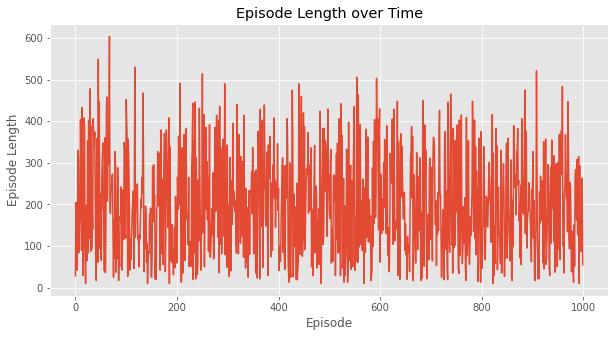

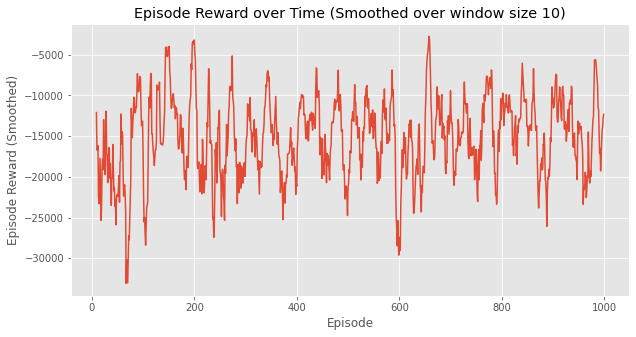

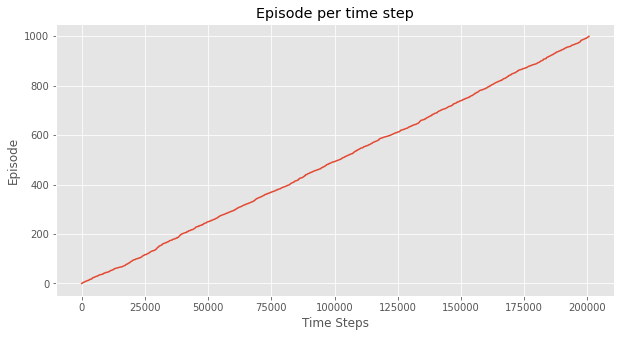

Stats for agent 1
Average reward for agent 1: -57.04927051600731


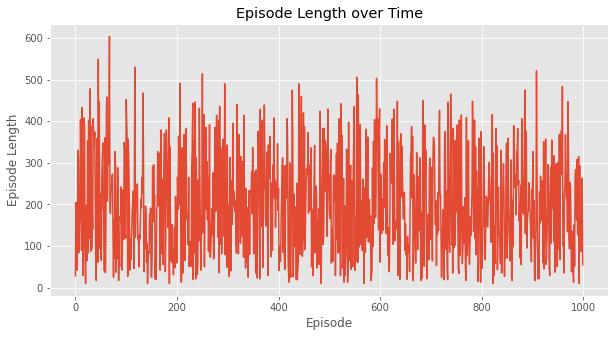

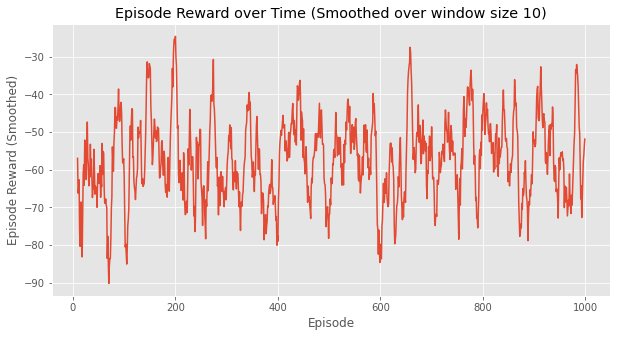

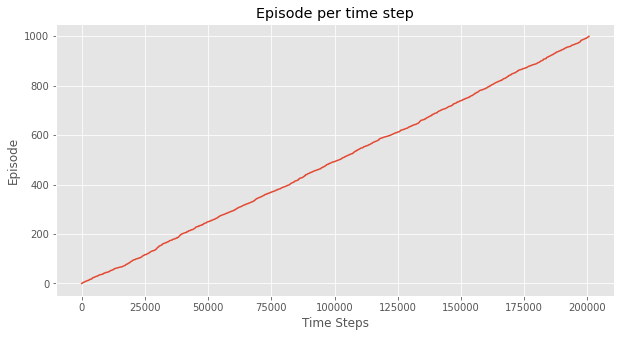

In [55]:
import plotting_custom
for ind, stat in enumerate(RUQL_UCB_BANDIT_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(RUQL_UCB_BANDIT_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

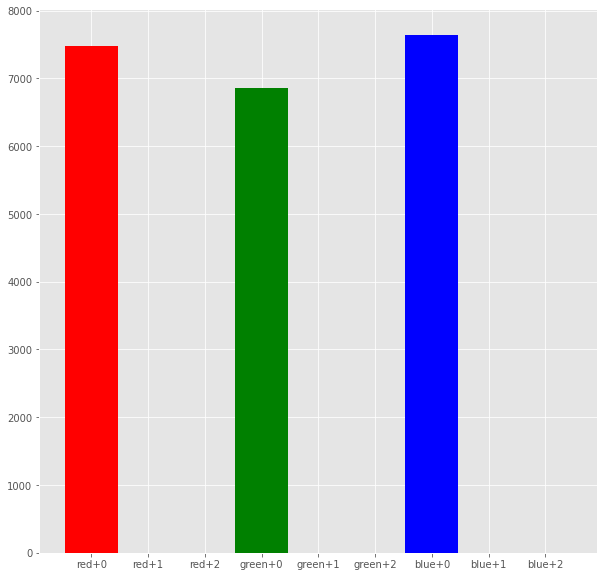

In [36]:
import matplotlib
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
locs = [4*i for i in range(9)]
plt.bar(locs, RUQL_UCB_comm, color=['red', 'red', 'red', 'green', 'green', 'green', 'blue', 'blue', 'blue'], width=[3.75 for _ in range(9)])#, 'cyan', 'cyan', 'cyan', 'magenta', 'magenta', 'magenta', 'yellow', 'yellow', 'yellow'], width=[3.75 for _ in range(9)])
plt.xticks(locs, ['red+0', 'red+1', 'red+2', 'green+0', 'green+1', 'green+2', 'blue+0', 'blue+1', 'blue+2'])#,'cyan+0', 'cyan+1', 'cyan+2', 'magenta+0', 'magenta+1', 'magenta+2', 'yellow+0', 'yellow+1', 'yellow+2'])
plt.show()

Stats for agent 0
Average reward for agent 0: -14.1588


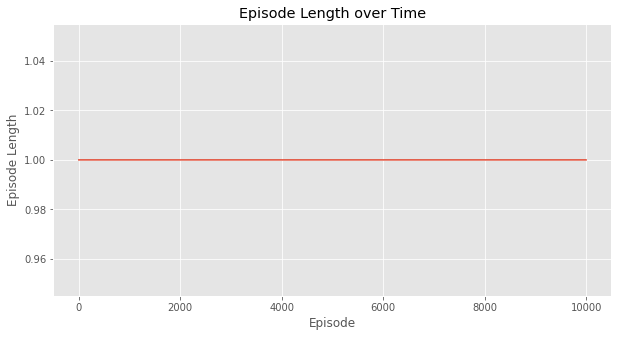

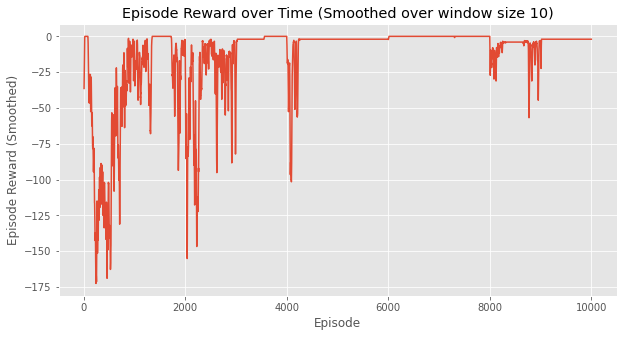

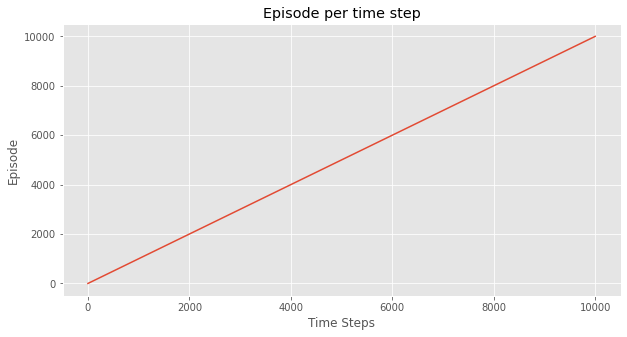

Stats for agent 1
Average reward for agent 1: -14.1588


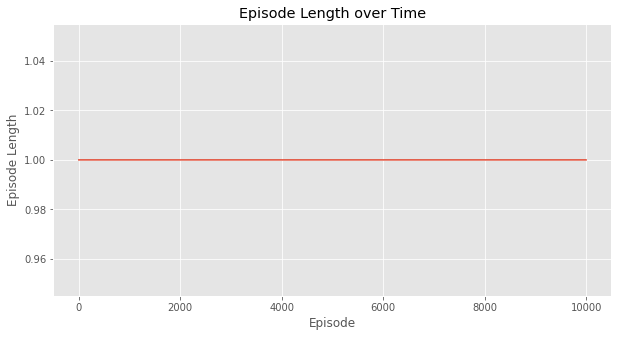

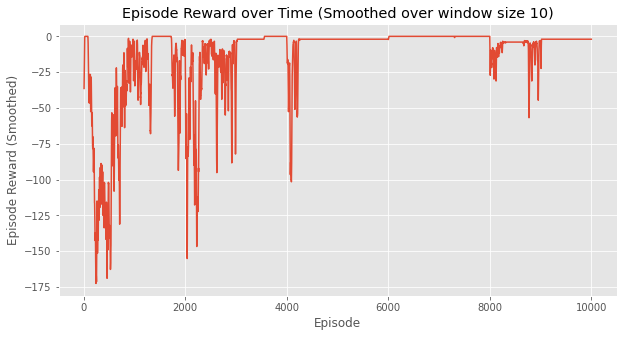

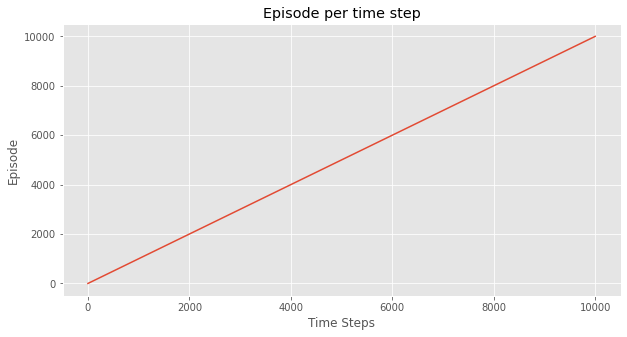

In [ ]:
import plotting_custom
for ind, stat in enumerate(RUQL_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(RUQL_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

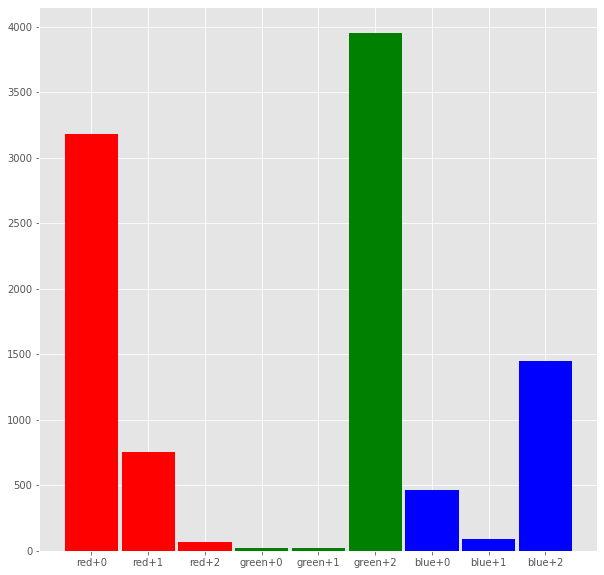

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
locs = [4*i for i in range(9)]
plt.bar(locs, RUQL_comm, color=['red', 'red', 'red', 'green', 'green', 'green', 'blue', 'blue', 'blue'], width=[3.75 for _ in range(9)])#, 'cyan', 'cyan', 'cyan', 'magenta', 'magenta', 'magenta', 'yellow', 'yellow', 'yellow'], width=[3.75 for _ in range(9)])
plt.xticks(locs, ['red+0', 'red+1', 'red+2', 'green+0', 'green+1', 'green+2', 'blue+0', 'blue+1', 'blue+2'])#,'cyan+0', 'cyan+1', 'cyan+2', 'magenta+0', 'magenta+1', 'magenta+2', 'yellow+0', 'yellow+1', 'yellow+2'])
plt.show()

In [ ]:
import plotting_custom
for ind, stat in enumerate(EXP3_DH_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(EXP3_DH_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

In [ ]:
import plotting_custom
for ind, stat in enumerate(EXP3_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(EXP3_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)